<h1> GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import numpy as np
from scipy.sparse import hstack
from tqdm import tqdm
import pandas as pd

# Training with Datapoints:50000

In [9]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows=50000)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [10]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [11]:
y=data["project_is_approved"]
x=data.drop("project_is_approved",axis=1)

In [12]:
x.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [13]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3,stratify=y)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [14]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [15]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

## 1.Tfidf

In [16]:
vectorizer= TfidfVectorizer(min_df=10, ngram_range=(1,4) ,max_features=5000)
vectorizer.fit(x_train["essay"])

x_train_tfidf_vect=vectorizer.transform(x_train["essay"]) #VECTORIZING TRAIN ESSAY BY TFIDF
x_test_tfidf_vect=vectorizer.transform(x_test["essay"]) #VECTORIZING TEST ESSAY BY TFIDF

print(x_train_tfidf_vect.shape)
print(x_test_tfidf_vect.shape)

(35000, 5000)
(15000, 5000)


## 2.Tfidf W2V

In [17]:
#VECTORIZING TRAIN ESSAY BY TFIDF Word 2 Vec
vectorizer=TfidfVectorizer()
tfidf= vectorizer.fit(x_train["essay"].values)

tfidf_dict = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())

x_train_essay_tfidfwv=[]
for i in tqdm(x_train["essay"].values):
    wv_vect=np.zeros(300)
    tfidf_weight=0
    for j in i.split():
        if j in glove_words and j in tfidf_words:
            word_vec = model[j]
            
            tfidf_value=tfidf_dict[j]*(i.count(j)/len(i.split()))
            multiply = word_vec * tfidf_value
            
            wv_vect += multiply
            tfidf_weight += tfidf_value
            
    x_train_essay_tfidfwv.append((wv_vect/tfidf_weight))

100%|██████████| 35000/35000 [03:50<00:00, 151.61it/s]


In [18]:
#VECTORIZING TEST ESSAY BY TFIDF Word 2 Vec
x_test_essay_tfidfwv=[]
for i in tqdm(x_test["essay"].values):
    wv_vect=np.zeros(300)
    tfidf_weight=0
    for j in i.split():
        if j in glove_words and j in tfidf_words:
            word_vec = model[j]
            
            tfidf_value=tfidf_dict[j]*(i.count(j)/len(i.split()))
            multiply = word_vec * tfidf_value
            
            wv_vect += multiply
            tfidf_weight += tfidf_value
            
    x_test_essay_tfidfwv.append((wv_vect/tfidf_weight))

100%|██████████| 15000/15000 [01:37<00:00, 153.50it/s]


In [19]:
print(len(x_train_essay_tfidfwv))
print(len(x_train_essay_tfidfwv[0]))

35000
300


In [20]:
print(len(x_test_essay_tfidfwv))
print(len(x_test_essay_tfidfwv[0]))

15000
300


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [21]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

## Categorical Features

In [22]:
# This function returns the positive and negative probabilities
#Arguments: 1) Categorical Column name
        # 2) Training data
        # 3) Test Data 
def response_encoding(colm,x_train,x_test):
    
    
    #This is table of total count of different categories in the feature
    total = pd.DataFrame(x_train[colm].value_counts()) 
    
    # This is table of total  count of  different  categories in feature for yi=0
    zero= pd.DataFrame(x_train[y_train==0][colm].value_counts())
    
    # This is table of total  count of  different  categories in feature for yi=1
    one= pd.DataFrame(x_train[y_train==1][colm].value_counts())
    
    # Here all three tables are merged 
    df= pd.merge(left=total,right=zero,how="left",left_index=True,right_index=True)
    df1=df.merge(one,left_index=True,right_index=True)
    
    # The NaN is filled with zero because there is no of count for that feature 
    df1=df1.fillna(0)
    
     
    df1.columns=["total","zero","one"] # Renaming the columns
    
    #For neg prob divide "zero" column with "total"
    df1["zero_prob"]=df1["zero"]/df1["total"]
    
    #For pos probability divide "one" column with "total"
    df1["one_prob"]=df1["one"]/df1["total"]
    
    # Here we drop the columns which contain counts of categories 
    df1.drop(["total","zero","one"],axis=1,inplace=True)

    # At this point we have a table with only two columns zero prob and one prob
    
    
    
    #For training data to get the probability score we are merging both x train and df1 table with key as categories in feature. 
    x_tr=pd.DataFrame(x_train[colm]).merge(df1,how="left",left_on=colm,right_index=True)
     #Here we are dropping the categories column and we are left with only pos porb and neg prob of x train data. 
    x_tr.drop(colm,axis=1,inplace=True) 
    
    #Similarly for test data to get the probability score we are merging both x test and df1 table with key as categories in feature
    x_te= pd.DataFrame(x_test[colm]).merge(df1,how="left",left_on=colm,right_index=True)
    #Here we are dropping the categories column and we are left with only pos porb and neg prob of x test data.
    x_te.drop(colm,axis=1,inplace=True)
    
    #Particularly in test data if any NaN is found in pos prob and neg prob 0.5 value is given to both.
    x_te.fillna(0.5)
    
    #returning the response encoded data.
    return x_tr,x_te



## 1.school_state

In [23]:
x_train_state,x_test_state=response_encoding("school_state",x_train,x_test)

In [24]:
x_train_state

,zero_prob,one_prob
9824,0.173800,0.826200
3225,0.143818,0.856182
35480,0.158537,0.841463
20601,0.148810,0.851190
4017,0.173800,0.826200
...,...,...
3577,0.182609,0.817391
17978,0.182328,0.817672
38403,0.156486,0.843514
13077,0.176080,0.823920


In [25]:
x_test_state

,zero_prob,one_prob
17122,0.182328,0.817672
38901,0.158537,0.841463
39904,0.156486,0.843514
44351,0.156486,0.843514
23165,0.161290,0.838710
...,...,...
9520,0.157485,0.842515
41009,0.175414,0.824586
42790,0.157676,0.842324
46593,0.175414,0.824586


## 2. teacher_prefix

In [26]:
x_train_prefix,x_test_prefix=response_encoding("teacher_prefix",x_train,x_test)

In [27]:
x_train_prefix

,zero_prob,one_prob
9824,0.153875,0.846125
3225,0.153875,0.846125
35480,0.153875,0.846125
20601,0.153875,0.846125
4017,0.153875,0.846125
...,...,...
3577,0.153875,0.846125
17978,0.153875,0.846125
38403,0.153875,0.846125
13077,0.166458,0.833542


In [28]:
x_test_prefix

,zero_prob,one_prob
17122,0.164656,0.835344
38901,0.166458,0.833542
39904,0.153875,0.846125
44351,0.153875,0.846125
23165,0.153875,0.846125
...,...,...
9520,0.153875,0.846125
41009,0.164656,0.835344
42790,0.153875,0.846125
46593,0.153875,0.846125


## 3. project_grade_category

In [29]:
x_train_grade, x_test_grade = response_encoding("project_grade_category",x_train,x_test)

In [30]:
x_train_grade

,zero_prob,one_prob
9824,0.161515,0.838485
3225,0.160122,0.839878
35480,0.160122,0.839878
20601,0.155324,0.844676
4017,0.160122,0.839878
...,...,...
3577,0.170261,0.829739
17978,0.170261,0.829739
38403,0.170261,0.829739
13077,0.160122,0.839878


In [31]:
x_test_grade

,zero_prob,one_prob
17122,0.160122,0.839878
38901,0.155324,0.844676
39904,0.155324,0.844676
44351,0.160122,0.839878
23165,0.160122,0.839878
...,...,...
9520,0.170261,0.829739
41009,0.170261,0.829739
42790,0.155324,0.844676
46593,0.160122,0.839878


## 4. clean_categories

In [32]:
x_train_categories, x_test_categories = response_encoding("clean_categories",x_train,x_test)

In [33]:
x_train_categories

,zero_prob,one_prob
9824,0.140615,0.859385
3225,0.146943,0.853057
35480,0.142648,0.857352
20601,0.142648,0.857352
4017,0.146943,0.853057
...,...,...
3577,0.163669,0.836331
17978,0.197753,0.802247
38403,0.199377,0.800623
13077,0.226708,0.773292


In [34]:
x_test_categories

,zero_prob,one_prob
17122,0.196294,0.803706
38901,0.196294,0.803706
39904,0.147277,0.852723
44351,0.144728,0.855272
23165,0.163669,0.836331
...,...,...
9520,0.155844,0.844156
41009,0.196294,0.803706
42790,0.206349,0.793651
46593,0.146943,0.853057


## 5. clean_subcategories

In [35]:
x_train_subcategories, x_test_subcategories = response_encoding("clean_subcategories",x_train,x_test)

In [36]:
x_train_subcategories

,zero_prob,one_prob
9824,0.122699,0.877301
3225,0.129202,0.870798
35480,0.223776,0.776224
20601,0.119328,0.880672
4017,0.129202,0.870798
...,...,...
3577,0.175926,0.824074
17978,0.181818,0.818182
38403,0.229508,0.770492
13077,0.266667,0.733333


In [37]:
x_test_subcategories

,zero_prob,one_prob
17122,0.204984,0.795016
38901,0.183930,0.816070
39904,0.103896,0.896104
44351,0.146351,0.853649
23165,0.175926,0.824074
...,...,...
9520,0.166667,0.833333
41009,0.180000,0.820000
42790,0.192982,0.807018
46593,0.159957,0.840043


# Numerical Features

### 1.teacher_number_of_previously_posted_projects

In [38]:
# NORMALIZING teacher_number_of_previously_posted_projects
normalizer= Normalizer()
normalizer.fit(x_train["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))

x_train_previous_project=normalizer.transform(x_train["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))
x_test_previous_project=normalizer.transform(x_test["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))

print(x_train_previous_project.shape)
print(x_test_previous_project.shape)

(35000, 1)
(15000, 1)


### 2. price

In [39]:
# NORMALIZING price
normalizer= Normalizer()
normalizer.fit(x_train["price"].values.reshape(-1,1))

x_train_price=normalizer.transform(x_train["price"].values.reshape(-1,1))
x_test_price=normalizer.transform(x_test["price"].values.reshape(-1,1))

print(x_train_price.shape)
print(x_test_price.shape)

(35000, 1)
(15000, 1)


# Sentiment scores

In [40]:
#COMPUTE SENTIMENT SCORE FOR TRAIN DATASET
sentiment=SentimentIntensityAnalyzer()
negative_train=[] #FOR STORING NEGATIVE SENTIMENT SCORE
neutral_train=[]  #FOR STORING NEUTRAL SENTIMENT SCORE
positive_train=[] #FOR STORING POSITIVE SENTIMENT SCORE
compound_train=[]  #FOR STORING COMPOUND SENTIMENT SCORE

for i in tqdm(x_train["essay"]): # FOR ALL PROCESSED ESSAY IN DATASET
    
    a=sentiment.polarity_scores(i) #COMPUTE SENTIMENT SCORE
    
    negative_train.append(a["neg"]) #APPENDING NEGATIVE SENTIMENT SCORE
    neutral_train.append(a["neu"])  #APPENDING NEUTRAL SENTIMENT SCORE
    positive_train.append(a["pos"])  #APPENDING POSITIVE SENTIMENT SCORE
    compound_train.append(a["compound"])  #APPENDING COMPOUND SENTIMENT SCORE

# CONVERTING TO ARRAY DATATYPE
negative_train=np.array(negative_train)
neutral_train=np.array(neutral_train)
positive_train=np.array(positive_train)
compound_train=np.array(compound_train)

100%|██████████| 35000/35000 [02:59<00:00, 195.43it/s]


In [41]:
#COMPUTE SENTIMENT SCORE FOR TRAIN DATASET
negative_test=[] #FOR STORING NEGATIVE SENTIMENT SCORE
neutral_test=[]  #FOR STORING NEUTRAL SENTIMENT SCORE
positive_test=[]  #FOR STORING POSITIVE SENTIMENT SCORE
compound_test=[]  #FOR STORING COMPOUND SENTIMENT SCORE

for i in tqdm(x_test["essay"]):  # FOR ALL PROCESSED ESSAY IN DATASET
    
    a=sentiment.polarity_scores(i) #COMPUTE SENTIMENT SCORE
    
    negative_test.append(a["neg"]) #APPENDING NEGATIVE SENTIMENT SCORE
    neutral_test.append(a["neu"]) #APPENDING NEUTRAL SENTIMENT SCORE
    positive_test.append(a["pos"]) #APPENDING POSITIVE SENTIMENT SCORE
    compound_test.append(a["compound"]) #APPENDING COMPOUND SENTIMENT SCORE

# CONVERTING TO ARRAY DATATYPE    
negative_test=np.array(negative_test)
neutral_test=np.array(neutral_test)
positive_test=np.array(positive_test)
compound_test=np.array(compound_test)

100%|██████████| 15000/15000 [01:14<00:00, 200.63it/s]


# CONCATINATE

## 1. Tfidf Concat

In [42]:
x_train_tfidf_vector=hstack( (x_train_prefix,x_train_grade,x_train_state,x_train_categories,x_train_subcategories,x_train_price,x_train_previous_project,x_train_tfidf_vect,negative_train.reshape(-1,1),neutral_train.reshape(-1,1),positive_train.reshape(-1,1),compound_train.reshape(-1,1))).tocsr()
x_test_tfidf_vector=hstack( (x_test_prefix,x_test_grade,x_test_state,x_test_categories,x_test_subcategories,x_test_price,x_test_previous_project,x_test_tfidf_vect,negative_test.reshape(-1,1),neutral_test.reshape(-1,1),positive_test.reshape(-1,1),compound_test.reshape(-1,1))).tocsr()

In [43]:
x_train_tfidf_vector.shape

(35000, 5016)

In [44]:
x_test_tfidf_vector.shape

(15000, 5016)

## 2. Tfidf W2V Concat

In [45]:
x_train_tfidfwv_vector=hstack( (x_train_prefix,x_train_grade,x_train_state,x_train_categories,x_train_subcategories,x_train_price,x_train_previous_project,x_train_essay_tfidfwv,negative_train.reshape(-1,1),neutral_train.reshape(-1,1),positive_train.reshape(-1,1),compound_train.reshape(-1,1))).tocsr()
x_test_tfidfwv_vector=hstack( (x_test_prefix,x_test_grade,x_test_state,x_test_categories,x_test_subcategories,x_test_price,x_test_previous_project,x_test_essay_tfidfwv,negative_test.reshape(-1,1),neutral_test.reshape(-1,1),positive_test.reshape(-1,1),compound_test.reshape(-1,1))).tocsr()

In [46]:
x_train_tfidfwv_vector.shape

(35000, 316)

In [47]:
x_test_tfidfwv_vector.shape

(15000, 316)

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

## Hyperparameter Tuning (Set 1)

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [48]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [49]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [50]:
model= XGBClassifier(scale_pos_weight=100)
parameter= {"n_estimators":[5,10,50, 75, 100, 200],"learing_rate":[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]  }
clf=GridSearchCV(estimator=model,param_grid=parameter,cv=3,error_score="roc_auc",return_train_score=True,n_jobs=-1)
clf.fit(x_train_tfidf_vector,y_train)

[14:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3, error_score='roc_auc',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=100,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
   

In [81]:
results=pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learing_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,31.365646,1.044709,3.775995,0.228793,0.0001,5,"{'learing_rate': 0.0001, 'n_estimators': 5}",0.840233,0.839976,0.840305,0.840171,0.000141,19,0.840441,0.840398,0.841047,0.840629,0.000297
1,53.801996,6.540802,3.778732,0.978408,0.0001,10,"{'learing_rate': 0.0001, 'n_estimators': 10}",0.840147,0.840147,0.840134,0.840143,0.000006,31,0.840183,0.840355,0.841476,0.840671,0.000573
2,284.820345,0.906942,4.773528,0.147987,0.0001,50,"{'learing_rate': 0.0001, 'n_estimators': 50}",0.840919,0.840147,0.840477,0.840514,0.000316,1,0.844512,0.843698,0.845247,0.844486,0.000633
3,423.706244,2.284304,4.567190,0.385704,0.0001,75,"{'learing_rate': 0.0001, 'n_estimators': 75}",0.840747,0.840319,0.840305,0.840457,0.000205,7,0.849098,0.847212,0.848761,0.848357,0.000821
4,1960.849361,17.287454,3.600946,0.881264,0.0001,100,"{'learing_rate': 0.0001, 'n_estimators': 100}",0.840576,0.840319,0.839962,0.840286,0.000252,13,0.854069,0.852141,0.852661,0.852957,0.000815
5,1565.196690,627.390399,5.368782,0.887544,0.0001,200,"{'learing_rate': 0.0001, 'n_estimators': 200}",0.839890,0.840062,0.840477,0.840143,0.000246,25,0.883513,0.878541,0.878161,0.880071,0.002438
6,18.191581,0.318762,4.045130,1.920050,0.001,5,"{'learing_rate': 0.001, 'n_estimators': 5}",0.840233,0.839976,0.840305,0.840171,0.000141,19,0.840441,0.840398,0.841047,0.840629,0.000297
7,57.365395,13.977821,6.343186,1.552747,0.001,10,"{'learing_rate': 0.001, 'n_estimators': 10}",0.840147,0.840147,0.840134,0.840143,0.000006,31,0.840183,0.840355,0.841476,0.840671,0.000573
8,344.222912,31.907432,5.667221,1.282054,0.001,50,"{'learing_rate': 0.001, 'n_estimators': 50}",0.840919,0.840147,0.840477,0.840514,0.000316,1,0.844512,0.843698,0.845247,0.844486,0.000633
9,430.963169,1.788785,4.615715,0.204337,0.001,75,"{'learing_rate': 0.001, 'n_estimators': 75}",0.840747,0.840319,0.840305,0.840457,0.000205,7,0.849098,0.847212,0.848761,0.848357,0.000821


In [76]:
train_score=results[["param_learing_rate","param_n_estimators","mean_train_score"]].pivot(index="param_learing_rate",columns="param_n_estimators",values="mean_train_score")
cv_score=results[["param_learing_rate","param_n_estimators","mean_test_score"]].pivot(index="param_learing_rate",columns="param_n_estimators",values="mean_test_score")


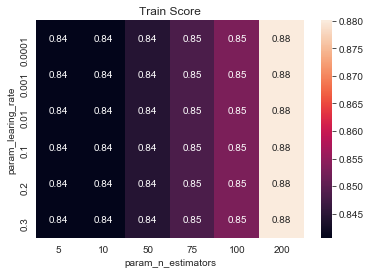

In [77]:

sns.heatmap(train_score,annot=True)
plt.title("Train Score")
plt.show()

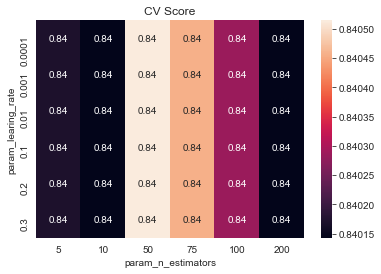

In [78]:

sns.heatmap(cv_score,annot=True)
plt.title("CV Score")
plt.show()

In [95]:
best_learing_rate=0.01
best_n_estimator=50

[20:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


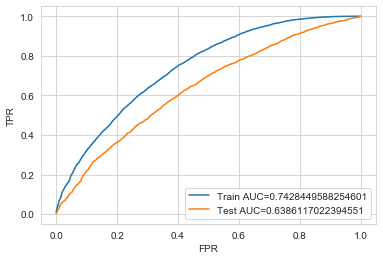

In [84]:
#Training with best_depth and best_n_estimator (Set1)
clf1= XGBClassifier(n_estimator=50,learning_rate=0.01) ##INITIALIZING THE CLASSIFIER
clf1.fit(x_train_tfidf_vector,y_train) #FITTING THE TRAIN DATESET 

y_train_tfidf_pred= clf1.predict_proba(x_train_tfidf_vector) #PREDICTING THE PROBABILITY FOR TRAIN DATASET
y_test_tfidf_pred= clf1.predict_proba(x_test_tfidf_vector) #PREDICTING THE PROBIBILITY FOR TEST DATASET

# COMPUTING FPR ,TPR ,THRESHOLD
train_fpr_tfidf,train_tpr_tfidf, train_thresholds_tfidf=roc_curve(y_train,y_train_tfidf_pred[:,1])
test_fpr_tfidf,test_tpr_tfidf, test_thresholds_tfidf=roc_curve(y_test,y_test_tfidf_pred[:,1])
# PLOTTING FPR VS TPR 
sns.set_style("whitegrid")
sns.lineplot(x=train_fpr_tfidf , y=train_tpr_tfidf , label="Train AUC=" +  str(auc(train_fpr_tfidf,train_tpr_tfidf)))
sns.lineplot(x=test_fpr_tfidf , y=test_tpr_tfidf , label="Test AUC=" + str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [85]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i >= threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [98]:
best_t_tfidf = find_best_threshold(train_thresholds_tfidf,train_fpr_tfidf,train_tpr_tfidf)

the maximum value of tpr*(1-fpr) 0.4516583633759558 for threshold 0.709


Train confusion matrix


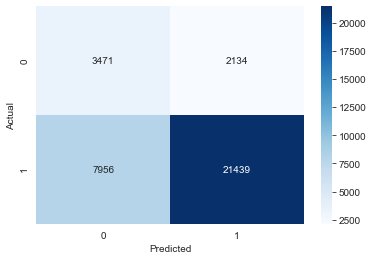

In [99]:
from sklearn.metrics import confusion_matrix
#Computing Confusion Matrix
cm_train_tfidf=confusion_matrix(y_train, predict_with_best_t(y_train_tfidf_pred[:,1], best_t_tfidf))
print("Train confusion matrix")

# PLOTTING CONFUSION MATRIX AS HEAT MAP FOR TRAIN DATASET(SET 1)
sns.heatmap(cm_train_tfidf, annot=True,fmt="d",cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Test confusion matrix


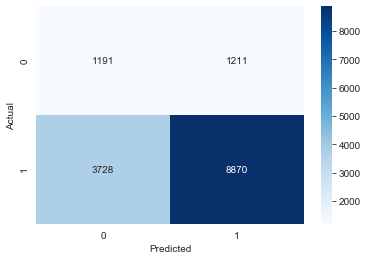

In [100]:
# CONFUSION MATRIX
cm_test_tfidf = confusion_matrix(y_test, predict_with_best_t(y_test_tfidf_pred[:,1] , best_t_tfidf))
print("Test confusion matrix")

# PLOTTING CONFUSION MATRIX AS HEAT MAP FOR TEST DATASET(SET 1)
sns.heatmap(cm_test_tfidf, annot=True,fmt="d",cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Hyperparameter Tuning (Set 2)

In [89]:
model_wv= XGBClassifier(scale_pos_weight=100)
parameter={"n_estimators":[5,10,50, 75, 100, 200],"learing_rate":[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] }
clf_wv=GridSearchCV(estimator=model,param_grid=parameter,cv=3,error_score="roc_auc",return_train_score=True,n_jobs=-1)
clf_wv.fit(x_train_tfidfwv_vector,y_train)

[00:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3, error_score='roc_auc',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
  

In [106]:
results_wv=pd.DataFrame(clf_wv.cv_results_)
results_wv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learing_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,41.825167,0.072555,7.344177,0.010150,0.0001,5,"{'learing_rate': 0.0001, 'n_estimators': 5}",0.838605,0.838690,0.839105,0.838800,0.000219,1,0.847898,0.846055,0.846533,0.846829,0.000781
1,70.688477,8.794159,7.278114,1.363771,0.0001,10,"{'learing_rate': 0.0001, 'n_estimators': 10}",0.837747,0.838947,0.837991,0.838229,0.000518,7,0.854669,0.852098,0.852704,0.853157,0.001098
2,338.496021,4.584686,8.292515,0.226963,0.0001,50,"{'learing_rate': 0.0001, 'n_estimators': 50}",0.834919,0.833205,0.835591,0.834571,0.001005,13,0.930828,0.932242,0.925945,0.929671,0.002698
3,508.834672,2.189851,7.927854,0.323929,0.0001,75,"{'learing_rate': 0.0001, 'n_estimators': 75}",0.833119,0.832262,0.835762,0.833714,0.001490,25,0.968628,0.968628,0.965244,0.967500,0.001595
4,648.275755,8.632972,8.558096,0.748477,0.0001,100,"{'learing_rate': 0.0001, 'n_estimators': 100}",0.834576,0.832348,0.833876,0.833600,0.000931,31,0.987400,0.989543,0.987486,0.988143,0.000990
5,1244.602576,10.578307,8.316327,0.672592,0.0001,200,"{'learing_rate': 0.0001, 'n_estimators': 200}",0.832948,0.833976,0.835505,0.834143,0.001051,19,0.999743,0.999786,0.999829,0.999786,0.000035
6,50.767277,1.080219,10.228115,2.106332,0.001,5,"{'learing_rate': 0.001, 'n_estimators': 5}",0.838605,0.838690,0.839105,0.838800,0.000219,1,0.847898,0.846055,0.846533,0.846829,0.000781
7,85.966913,2.737188,10.282657,1.880264,0.001,10,"{'learing_rate': 0.001, 'n_estimators': 10}",0.837747,0.838947,0.837991,0.838229,0.000518,7,0.854669,0.852098,0.852704,0.853157,0.001098
8,338.120259,4.820423,8.389841,0.228799,0.001,50,"{'learing_rate': 0.001, 'n_estimators': 50}",0.834919,0.833205,0.835591,0.834571,0.001005,13,0.930828,0.932242,0.925945,0.929671,0.002698
9,505.113282,0.831101,8.421227,0.246167,0.001,75,"{'learing_rate': 0.001, 'n_estimators': 75}",0.833119,0.832262,0.835762,0.833714,0.001490,25,0.968628,0.968628,0.965244,0.967500,0.001595


In [107]:
train_score_wv= results_wv[["param_learing_rate","param_n_estimators","mean_train_score"]].pivot(index="param_learing_rate",columns="param_n_estimators",values="mean_train_score")
cv_score_wv= results_wv[["param_learing_rate","param_n_estimators","mean_test_score"]].pivot(index="param_learing_rate",columns="param_n_estimators",values="mean_test_score")


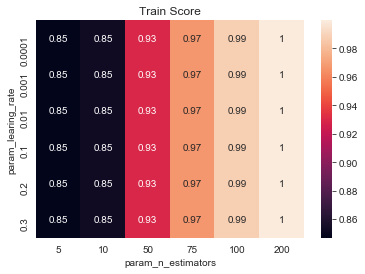

In [108]:
sns.heatmap(train_score_wv, annot=True)
plt.title("Train Score")
plt.show()

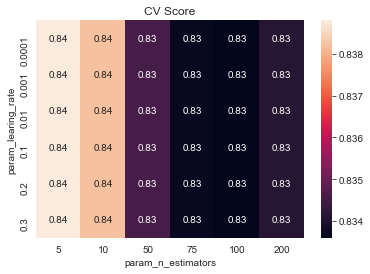

In [109]:
sns.heatmap(cv_score_wv,annot=True)
plt.title("CV Score")
plt.show()

In [117]:
best_learning_rate=0.001
best_n_estimator=5

[00:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:55:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


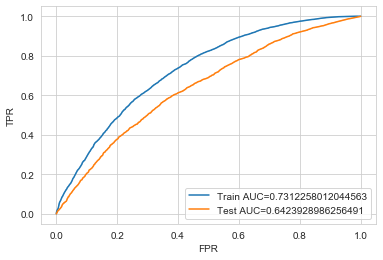

In [111]:
#Training with best_depth and best_n_estimator (Set1)
clf_wv= XGBClassifier(n_estimator=5,learning_rate=0.001) ##INITIALIZING THE CLASSIFIER
clf_wv.fit(x_train_tfidfwv_vector,y_train) #FITTING THE TRAIN DATESET 

y_train_tfidfwv_pred= clf_wv.predict_proba(x_train_tfidfwv_vector) #PREDICTING THE PROBABILITY FOR TRAIN DATASET
y_test_tfidfwv_pred= clf_wv.predict_proba(x_test_tfidfwv_vector) #PREDICTING THE PROBIBILITY FOR TEST DATASET

# COMPUTING FPR ,TPR ,THRESHOLD
train_fpr_tfidfwv,train_tpr_tfidfwv, train_thresholds_tfidfwv=roc_curve(y_train,y_train_tfidfwv_pred[:,1])
test_fpr_tfidfwv,test_tpr_tfidfwv, test_thresholds_tfidfwv=roc_curve(y_test,y_test_tfidfwv_pred[:,1])

# PLOTTING FPR VS TPR 
sns.set_style("whitegrid")
sns.lineplot(x=train_fpr_tfidfwv , y=train_tpr_tfidfwv , label="Train AUC=" +  str(auc(train_fpr_tfidfwv,train_tpr_tfidfwv)))
sns.lineplot(x=test_fpr_tfidfwv , y=test_tpr_tfidfwv , label="Test AUC=" + str(auc(test_fpr_tfidfwv, test_tpr_tfidfwv)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


In [112]:
best_t_tfidfwv = find_best_threshold(train_thresholds_tfidfwv,train_fpr_tfidfwv,train_tpr_tfidfwv)

the maximum value of tpr*(1-fpr) 0.44661339389857213 for threshold 0.531


Train confusion matrix


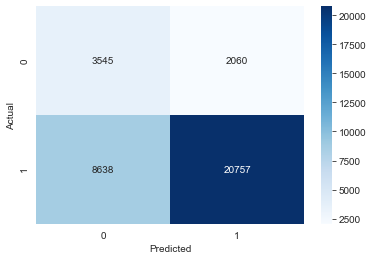

In [113]:
#Computing Confusion Matrix
cm_train_tfidfwv= confusion_matrix(y_train, predict_with_best_t(y_train_tfidfwv_pred[:,1], best_t_tfidfwv))
print("Train confusion matrix")

# PLOTTING CONFUSION MATRIX AS HEAT MAP FOR TRAIN DATASET(SET 1)
sns.heatmap(cm_train_tfidfwv, annot=True,fmt="d",cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Test confusion matrix


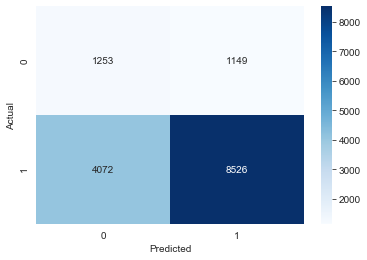

In [114]:
# CONFUSION MATRIX
cm_test_tfidfwv = confusion_matrix(y_test, predict_with_best_t(y_test_tfidfwv_pred[:,1] , best_t_tfidfwv))
print("Test confusion matrix")

# PLOTTING CONFUSION MATRIX AS HEAT MAP FOR TEST DATASET(SET 1)
sns.heatmap(cm_test_tfidfwv, annot=True,fmt="d",cmap='Blues')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [115]:
dict1={"Vectorizer":["TFIDF","TFIDF W2V",],"Model":["XGB Classifier","XGB Classifier"],"Best Learning Rate":[0.01,0.001],"Best n estimator":[50,5],"AUC":[0.6386,0.6424]}

In [116]:
pd.DataFrame(dict1)

,Vectorizer,Model,Best Learning Rate,Best n estimator,AUC
0,TFIDF,XGB Classifier,0.010,50,0.6386
1,TFIDF W2V,XGB Classifier,0.001,5,0.6424
